In [52]:
# HIDDEN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
sns.set(rc={'figure.figsize':(12,6)})

url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
recidivism = (
    pd.read_csv(url)
    .drop(['name', 'first', 'last'], axis=1)
    .assign(pred_recid=lambda x:x['score_text'].isin(['Medium', 'High']).astype(int))
)

# order for bar charts
order = ['African-American', 'Caucasian', 'Hispanic', 'Asian', 'Native American', 'Other']

# COMPAS Analysis II

In this section, we revisit the case of COMPAS, paying attention to observations made by parity criteria and understanding to what extent that existing COMPAS scores can give rise to fairer decisions.  

## Parity Measures

First, we examine the parity of recommended decisions by the COMPAS score, interpreting the results in turn. We will define the recommended decision to one that, according to ProPublica, broadly falls in line with usage in Broward County:
* An individual is predicted to re-offend if their COMPAS score is greater than or equal to 5. This corresponds to COMPAS labeling an individual medium or high risk.
* An individual is predicted to *not* re-offend if their COMPAS score is less than 5. This corresponds to COMPAS labeling an individual low risk.

Each parity measure is calculated with 95% confidence intervals.

**Demographic Parity**. The rates of predicted re-offense varies drastically:
1. Approximately 60% of Black and Native American defendants are predicted to re-offend
2. Approximately 30% of White, Hispanic, and Asian defendants are predicted to re-offend

Arguing for Demographic Parity to hold in this context is uncommon, as each group has different *true* rates of re-offense. In a fair society, one would assume that the crime-rates across different groups is identical. However, this is not currently the case. While imposing demographic parity as a long-term policy initiative is common for decisions related to *opportunity*, it makes less sense as a criteria for decisions that remove fundamental freedoms.

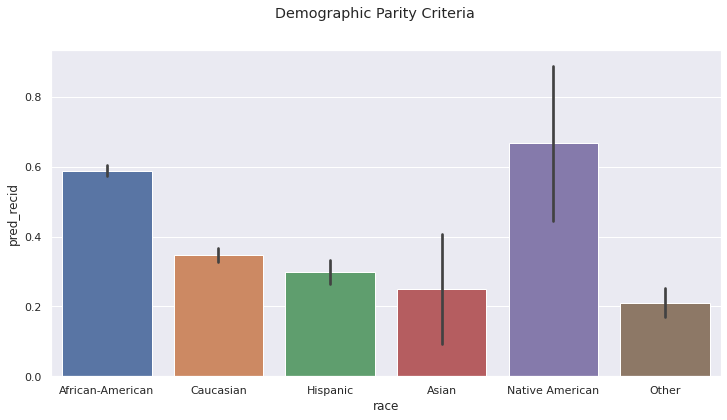

In [8]:
a = recidivism
sns.barplot(data=a, x='race', y='pred_recid', order=order)
plt.suptitle('Demographic Parity Criteria');

**Accuracy Parity**. The rates of accurate predictions are the same among groups, within the standard of error. Northpointe used this criteria when developing the COMPAS model. The model arrives at the *right* prediction 60% of the time.

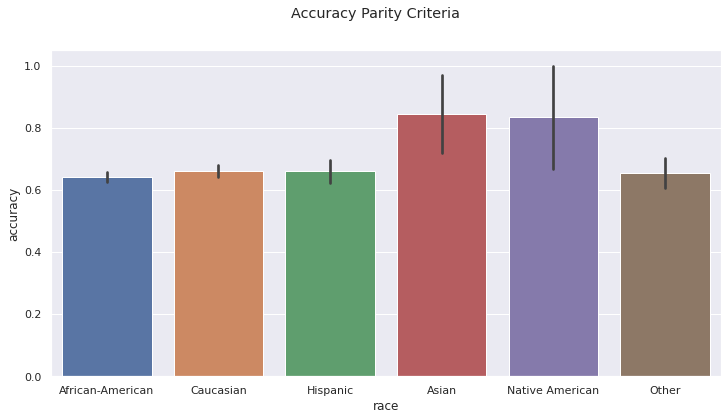

In [9]:
a = (
    recidivism
    .assign(
        accuracy=(~(recidivism['is_recid'] + recidivism['pred_recid']) % 2)
    )
)

sns.barplot(data=a, x='race', y='accuracy', order=order)
plt.suptitle('Accuracy Parity Criteria');

**Predictive Value Parity**. COMPAS largely maintains consistent rates of recidivism across groups, among populations they deem high and low risk. That is:
* Among those labeled high risk by COMPAS, approximately 60% re-offended
* Among those labeled low risk by COMPAS, approximately 60% did not re-offend.


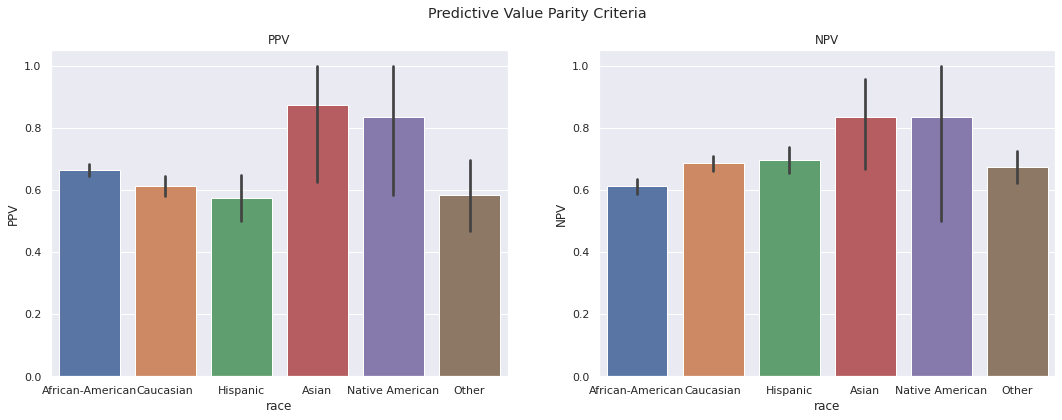

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

a1 = recidivism[recidivism['pred_recid'] == 1].assign(PPV=lambda x:x['is_recid'])
sns.barplot(data=a1, x='race', y='PPV', ax=ax1, order=order)
ax1.set_title('PPV')

a2 = recidivism[recidivism['pred_recid'] == 0].assign(NPV=lambda x:1 - x['is_recid'])
sns.barplot(data=a2, x='race', y='NPV', ax=ax2, order=order)
ax2.set_title('NPV');

plt.suptitle('Predictive Value Parity Criteria');

**Equalized Odds**. The False Positive and False Negative rates vary significantly across groups and Black defendants experience consistently unfair treatment as compared to other defendants.
* White defendants are improperly released 66% more often than Black defendants.
* Black defendants are improperly denied release twice as often as White defendants.

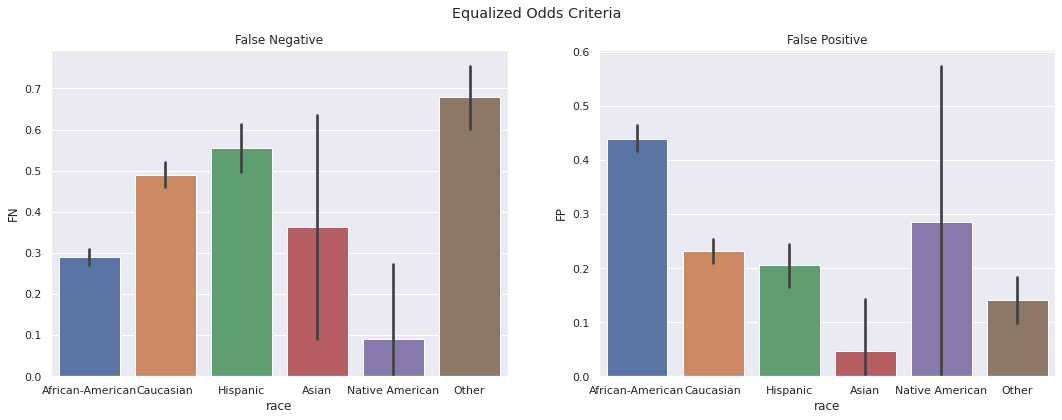

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

a1 = recidivism[recidivism['is_recid'] == 1].assign(FN=lambda x:1 - x['pred_recid'])
sns.barplot(data=a1, x='race', y='FN', ax=ax1, order=order)
ax1.set_title('False Negative')

a2 = recidivism[recidivism['is_recid'] == 0].assign(FP=lambda x:x['pred_recid'])
sns.barplot(data=a2, x='race', y='FP', ax=ax2, order=order)
ax2.set_title('False Positive');

plt.suptitle('Equalized Odds Criteria');

## Calibration

The COMPAS scores mean to capture the likelihood of re-offense by defendants. On the one hand, the distribution of risk across the population differs by group:
* COMPAS scores deem white defendants primarily low risk (60%), with very few predicted as high risk (10%).
* Black defendants risk scores are roughly uniformly distributed (40% low risk; 30% high risk).

Given all individuals considered here have been arrested, this difference likely points to differences in the behavior of the population (e.g. arrested for different crimes), as well as differences in what the COMPAS score attempts to measure. This difference in scores leads to drastically different racial make-up per decile.

In [12]:
cols = ['race', 'decile_score', 'is_recid']
df = recidivism[cols].loc[lambda x:x['race'].isin(['African-American', 'Caucasian'])]

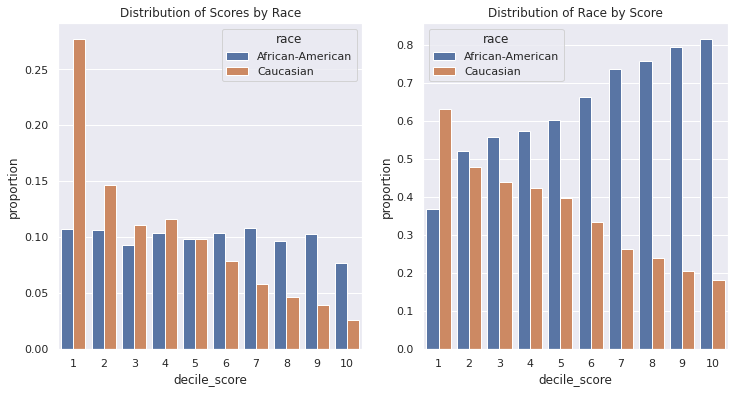

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2)

a1 = (
    df
    .groupby(['race'])['decile_score']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
    .sort_values(by='decile_score')
)

sns.barplot(data=a1, x='decile_score' ,y='proportion',hue='race', ax=ax1)
ax1.set_title('Distribution of Scores by Race')

a2 = (
    df
    .groupby(['decile_score'])['race']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
    .sort_values(by='race')
)

sns.barplot(data=a2, x='decile_score' ,y='proportion',hue='race', ax=ax2);
ax2.set_title('Distribution of Race by Score');

The condition for calibration given in ___ requires the proportion of recidivism in each decile grow with the decile. That is,

$$
P(Y = 1|S = p) = p
$$

In each COMPAS score, the recidivism rate increases approximately 10% with each decile, though the condition does not strictly hold.

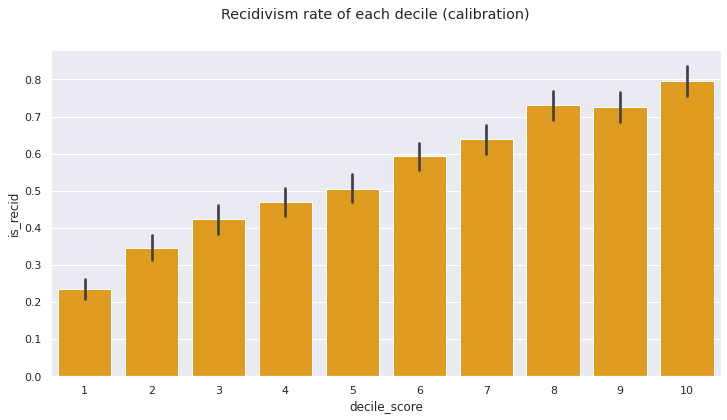

In [14]:
sns.barplot(data=df, x='decile_score', y='is_recid', color='orange')
plt.suptitle('Recidivism rate of each decile (calibration)');

COMPAS likely used a related notion of calibration. Among all re-offending individuals, $p$% of individuals have a score at least as high as $p$. Thus, if a threshold for a classifier is set at score $p$, that classifier would correctly predict $p$% of all re-offenses.


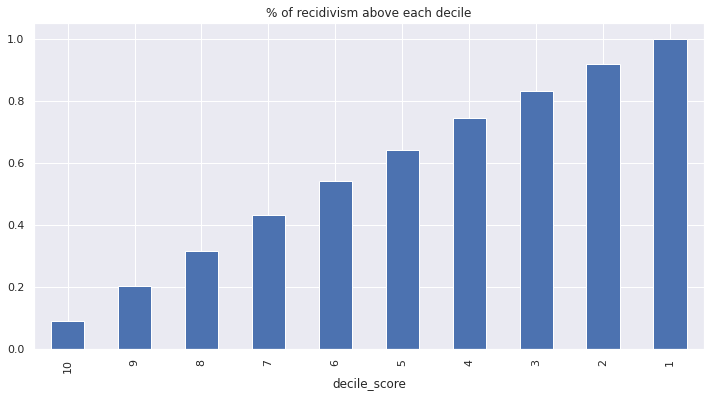

In [17]:
tots_by_dec = df.groupby('decile_score').is_recid.sum()

title = '% of recidivism above each decile'
(tots_by_dec.iloc[::-1].cumsum() / tots_by_dec.sum()).plot(kind='bar', title=title);

Within each group, the recidivism rates for each decile are similar:

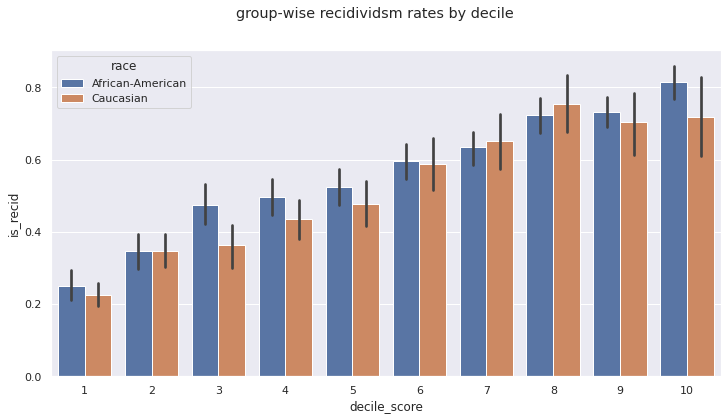

In [20]:
sns.barplot(data=df, x='decile_score', y='is_recid', hue='race')
plt.suptitle('group-wise recidividsm rates by decile');

On the other hand, the proportion of re-offenders below each potential threshold varies by race. Almost 40% of all recidivism in the Black population lies in the top three deciles, whereas the same 40% in the White population requires thresholding at the top five deciles.

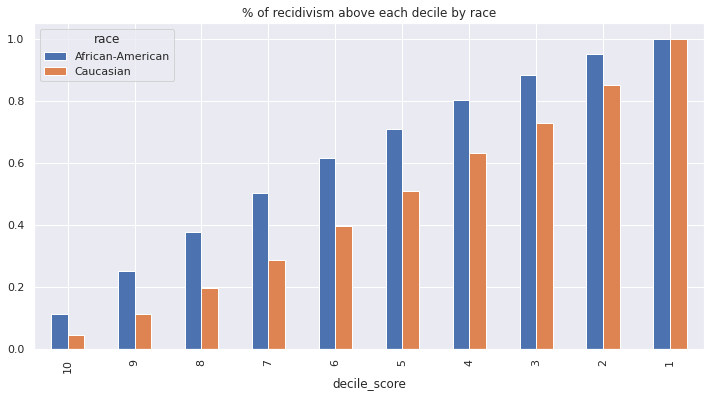

In [21]:
(
    df
    .groupby(['race', 'decile_score'])
    .is_recid
    .sum()    
    .rename('tot')
    .reset_index()
    .pivot(columns='race', index='decile_score', values='tot')
    .apply(lambda x:x / x.sum())
    .iloc[::-1,:]
    .cumsum()
).plot(kind='bar', title='% of recidivism above each decile by race');

## Balance of positive/negative class

Much like the equalized odds parity condition, balance of positive/negative class requires scores to be similar, conditional on the true outcome. COMPAS assigns much higher risk to Black defendants, regardless of whether they re-offended or not.

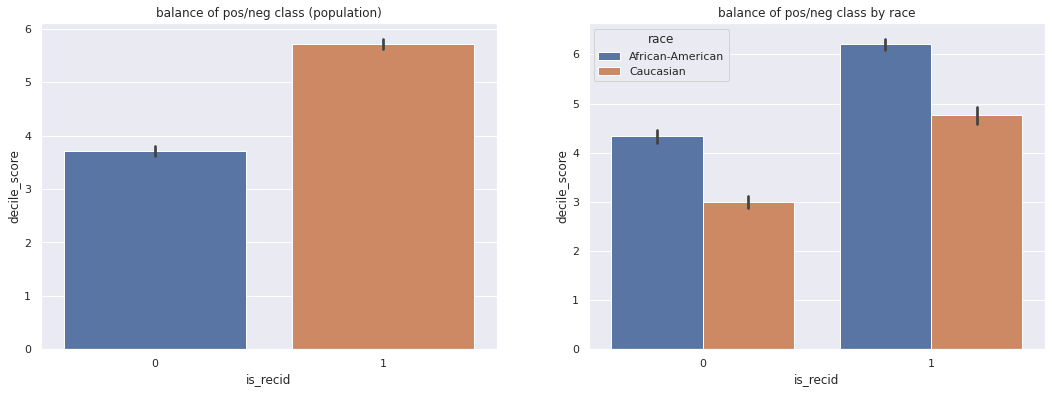

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

sns.barplot(data=df, x='is_recid', y='decile_score', ax = ax1)
ax1.set_title('balance of pos/neg class (population)')

sns.barplot(data=df, x='is_recid', y='decile_score', hue='race', ax=ax2)
ax2.set_title('balance of pos/neg class by race');

## ROC Curve

Judges use COMPAS deciles to make decisions, as well the text descriptors ("Low, Medium, High Risk") offered by Northpointe.  These text descriptors correspond to score thresholds of 4 and 7.

In [31]:
recidivism.groupby(['decile_score', 'score_text']).size().rename('counts').to_frame()

,,counts
decile_score,score_text,
1,Low,1440
2,Low,941
3,Low,747
4,Low,769
5,Medium,681
6,Medium,641
7,Medium,592
8,High,512
9,High,508


What if we could provide judges with an interpretation of these scores that are more sensitive to race? To this aim, we will analyze the scores of the COMPAS model more broadly. The ROC curve for the COMPAS score parameterizes prediction performance (TPR, FPR) by score thresholds:

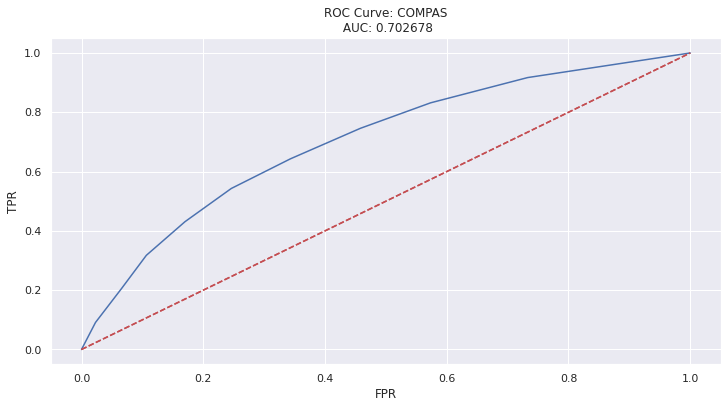

In [36]:
fpr, tpr, thresh = metrics.roc_curve(df['is_recid'], df['decile_score'])

ax = (
    pd.DataFrame(tpr, index=fpr)
    .plot(legend=False, title=('ROC Curve: COMPAS\n AUC: %f' % metrics.auc(fpr, tpr)))
)
ax.plot([(0,0), (1,1)], 'r--')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR');

Calculating separate ROC curves by group, we see similar overall performance. However, we do see two important differences in the curves:
1. The curve corresponding to the White population has higher TPR at *low* values of FPR.
2. The curve corresponding to the Black population has higher TPR at *high* values of FPR.

Any realistic choice of threshold (operating point) would fix a relatively low FPR, resulting in a model that performs better on the White population.

However, one sees a large difference in model characteristics when keeping track of where the score thresholds lie. The granularity of the thresholds are concentrated at opposite ends of the respective curves; the scores mean different things for the different groups.

In [41]:
def calc_roc(x, **kwargs):
    
    fpr, tpr, thresh = metrics.roc_curve(x['is_recid'], x['decile_score'], **kwargs)
    return pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresh': thresh})

a = df.groupby('race').apply(calc_roc).reset_index(level=0).reset_index(drop=True)
a_blk = a[a.race == 'African-American'].drop('race', axis=1).reset_index(drop=True)
a_wht = a[a.race == 'Caucasian'].drop('race', axis=1).reset_index(drop=True)

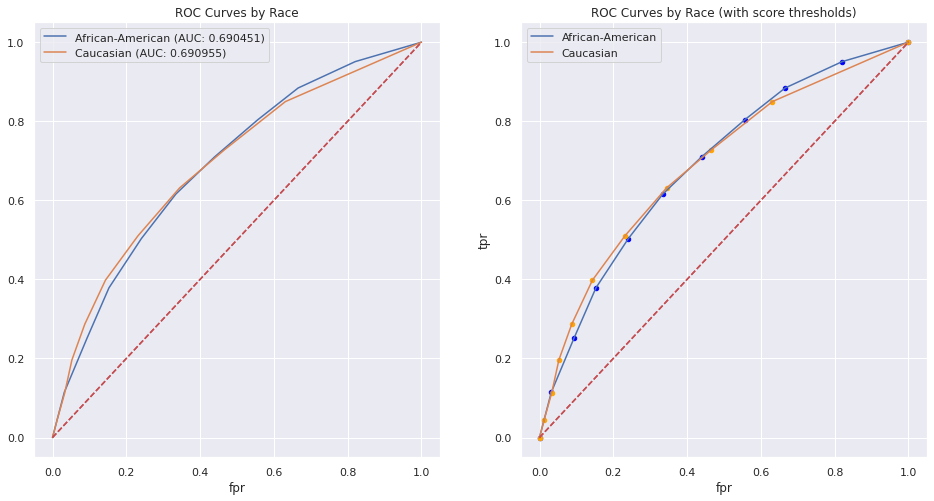

In [54]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

a_blk.plot(x='fpr', y='tpr', ax=ax1)
a_wht.plot(x='fpr', y='tpr', ax=ax1)
ax1.plot([(0,0), (1,1)], 'r--')

ax1.set_title('ROC Curves by Race')

auc_blk = metrics.auc(a_blk['fpr'], a_blk['tpr'])
auc_wht = metrics.auc(a_wht['fpr'], a_wht['tpr'])

ax1.legend(['African-American (AUC: %f)' % auc_blk, 'Caucasian (AUC: %f)' % auc_wht]);

a_blk.plot(x='fpr', y='tpr', ax=ax2)
a_blk.plot(kind='scatter', x='fpr', y='tpr', ax=ax2, c='blue')

a_wht.plot(x='fpr', y='tpr', ax=ax2)
a_wht.plot(kind='scatter', x='fpr', y='tpr', ax=ax2, c='orange')

ax2.plot([(0,0), (1,1)], 'r--')

ax2.set_title('ROC Curves by Race (with score thresholds)')

ax2.legend(['African-American', 'Caucasian']);

The differences in performance for given thresholds are easily read off the rows of the table:

In [56]:
pd.concat([a_wht.set_index('thresh'), a_blk.set_index('thresh')], axis=1, keys=['White', 'Black']).iloc[1:]

White               Black          
             fpr       tpr       fpr       tpr
thresh                                        
10      0.012596  0.044878  0.031928  0.114440
9       0.032890  0.112195  0.093373  0.250982
8       0.052484  0.196098  0.153012  0.378684
7       0.087474  0.286829  0.240964  0.503438
6       0.143457  0.398049  0.334337  0.615914
5       0.231631  0.510244  0.439157  0.709725
4       0.344297  0.631220  0.556024  0.803536
3       0.466060  0.727805  0.665663  0.884086
2       0.631211  0.849756  0.820482  0.950884
1       1.000000  1.000000  1.000000  1.000000

## Choosing a model (To be completed)

Is there a model from these scores that may be 'more fair' than the existing COMPAS recommendations?

* What is the 'best' model?
* Need to calculate the utility

In [622]:
def calc_utility(df, thresh, wt):

    return metrics.accuracy_score(
        df['is_recid'], 
        (df.decile_score >= thresh).astype(int), 
        sample_weight=df['is_recid'].replace({1: wt, 0:1})
    )

def find_best_thresh(df, wt=0.5):
    
    thresh, util = 0, 0
    for k in range(1, 11):
        m = calc_utility(df, k, wt)
        if m >= util:
            util = m
            thresh = k
    
    return thresh

In [623]:
a = pd.DataFrame(
    {str(round(i,2)):[calc_utility(df, k, i) for k in range(1,11)] for i in np.arange(0,1.01,0.1)}
).T

In [624]:
a

,0,1,2,3,4,5,6,7,8,9
0.0,0.000000,0.267077,0.426675,0.541923,0.656847,0.753966,0.830042,0.893493,0.934607,0.977015
0.1,0.090159,0.325675,0.463197,0.560308,0.655592,0.734942,0.794056,0.841566,0.868781,0.897146
0.2,0.165406,0.374581,0.493678,0.575651,0.654544,0.719064,0.764022,0.798228,0.813844,0.830487
0.3,0.229157,0.416016,0.519502,0.588651,0.653657,0.705612,0.738577,0.761510,0.767300,0.774012
0.4,0.283860,0.451570,0.541661,0.599805,0.652896,0.694070,0.716743,0.730004,0.727361,0.725553
0.5,0.331313,0.482412,0.560883,0.609482,0.652235,0.684057,0.697803,0.702673,0.692716,0.683516
0.6,0.372868,0.509420,0.577716,0.617955,0.651657,0.675288,0.681217,0.678740,0.662376,0.646703
0.7,0.409561,0.533268,0.592580,0.625437,0.651146,0.667546,0.666571,0.657607,0.635587,0.614198
0.8,0.442197,0.554480,0.605800,0.632092,0.650692,0.660659,0.653545,0.638810,0.611759,0.585287
0.9,0.471415,0.573470,0.617635,0.638050,0.650285,0.654494,0.641883,0.621982,0.590428,0.559404


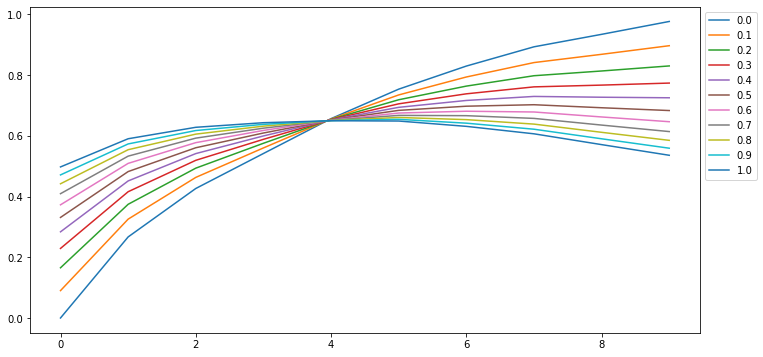

In [625]:
ax = a.T.plot(figsize=(12,6))
ax.legend(bbox_to_anchor=(1., 1.), bbox_transform=ax.transAxes);

### Single Threshold Model


In [626]:
find_best_thresh(df, wt=0.7)


6

### ROC Curve with best single threshold

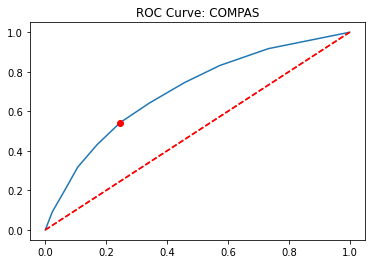

In [628]:
fpr, tpr, thresh = metrics.roc_curve(df['is_recid'], df['decile_score'])


ax = pd.DataFrame(tpr, index=fpr).plot(legend=False, title='ROC Curve: COMPAS')
ax.plot([fpr[5]], [tpr[5]], 'ro')
ax.plot([(0,0), (1,1)], 'r--');

### Threshold for each group

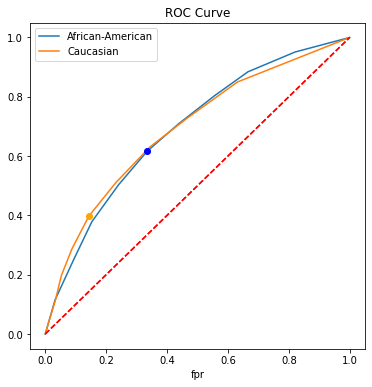

In [629]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

a_blk.plot(x='fpr', y='tpr', ax=ax)
a_wht.plot(x='fpr', y='tpr', ax=ax)
ax.plot([a_blk.loc[5, 'fpr']], [a_blk.loc[5, 'tpr']], 'bo')
ax.plot([a_wht.loc[5, 'fpr']], [a_wht.loc[5, 'tpr']], 'o', color='orange')

ax.plot([(0,0), (1,1)], 'r--')

ax.set_title('ROC Curve')

plt.legend(['African-American', 'Caucasian']);

### Group-aware thresholds

* Create a model with possibly different thresholds per group
* Race was *not* a variable for COMPAS.

In [630]:
find_best_thresh(df[df.race == 'Caucasian'], wt=0.7)

7

In [631]:
find_best_thresh(df[df.race == 'African-American'], wt=0.7)

6

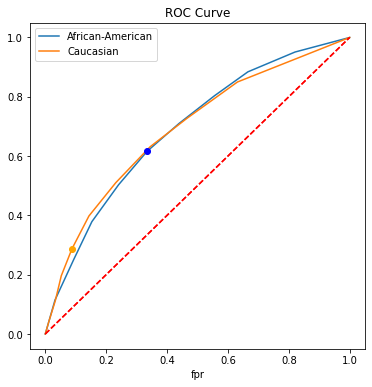

In [632]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

a_blk.plot(x='fpr', y='tpr', ax=ax)
a_wht.plot(x='fpr', y='tpr', ax=ax)
ax.plot([a_blk.loc[5, 'fpr']], [a_blk.loc[5, 'tpr']], 'bo')
ax.plot([a_wht.loc[4, 'fpr']], [a_wht.loc[4, 'tpr']], 'o', color='orange')

ax.plot([(0,0), (1,1)], 'r--')

ax.set_title('ROC Curve')

plt.legend(['African-American', 'Caucasian']);

### TPR-Parity / FPR-Parity / Equalized Odds

* Can we choose a 'best model' subject to Equalized Odds?
* Plot the ROC curves (or table) and figure it out by hand

In [633]:
pd.concat([a_wht.set_index('thresh'), a_blk.set_index('thresh')], axis=1, keys=['White', 'Black'])

White               Black          
             fpr       tpr       fpr       tpr
thresh                                        
11      0.000000  0.000000  0.000000  0.000000
10      0.012596  0.044878  0.031928  0.114440
9       0.032890  0.112195  0.093373  0.250982
8       0.052484  0.196098  0.153012  0.378684
7       0.087474  0.286829  0.240964  0.503438
6       0.143457  0.398049  0.334337  0.615914
5       0.231631  0.510244  0.439157  0.709725
4       0.344297  0.631220  0.556024  0.803536
3       0.466060  0.727805  0.665663  0.884086
2       0.631211  0.849756  0.820482  0.950884
1       1.000000  1.000000  1.000000  1.000000

* TPR-Parity at:
    - (Black, White) = (10, 9), (9,7), (8,6), (7,5), (6,4), (5,3)
    - Maximize utility at (8,6)
* FPR-Parity at:
    - (Black, White) = (10, 9), (8, 6), (7,5), (6,4)
    - Maximize utility at (8,6)
* Note: approximately equalized odds as well.
* What is PPV at (8,6)?

### Demographic Parity

* Demographic parity is not something asked for by any groups involved
* What would this look like?
* "same proportion of Black/White defendants predicted 'reoffend'

### Proportion White for each decile:

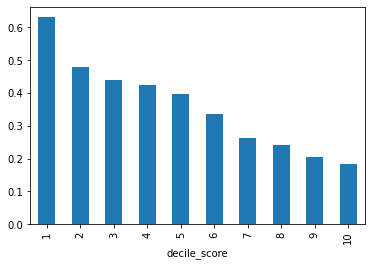

In [634]:
df.assign(is_white=(df['race'] == 'Caucasian').astype(int)).groupby('decile_score').is_white.mean().plot(kind='bar');

### What thresholds yield the best model, subject to Demographic Parity

* Iterate through all pairs of thresholds and calculate the decision by model
* Calculate proportion 'predict reoffend' to find demographic parity
* Find the pairs of thresholds with highest utility

In [635]:
sc = df.copy()
for tw in range(1,11):
    for tb in range(1,11):
        sc.loc[sc.race == 'Caucasian', 'decision_%d_%d' %(tw, tb)] = (sc.loc[sc.race == 'Caucasian', 'decile_score'] >= tw).astype(int)
        sc.loc[sc.race == 'African-American', 'decision_%d_%d' %(tw, tb)] = (sc.loc[sc.race == 'African-American', 'decile_score'] >= tb).astype(int)


In [636]:
demos = sc[['race'] + [x for x in sc.columns if 'decision_' in x]].groupby('race').mean().T
demos

race,African-American,Caucasian
decision_1_1,1.000000,1.000000
decision_1_2,0.892316,1.000000
decision_1_3,0.785985,1.000000
decision_1_4,0.692370,1.000000
decision_1_5,0.588203,1.000000
decision_1_6,0.489448,1.000000
decision_1_7,0.385552,1.000000
decision_1_8,0.277327,1.000000
decision_1_9,0.180195,1.000000
decision_1_10,0.077381,1.000000


In [638]:
(demos['African-American'] - demos['Caucasian']).sort_values().loc[lambda x:(-0.02 <= x) & (x <= 0.02)]

decision_1_1     0.000000
decision_7_9     0.009453
decision_9_10    0.011366
decision_3_5     0.012816
dtype: float64

In [639]:
def weighted_accuracy(df, col, wt=0.7):
    
    return metrics.accuracy_score(
        df['is_recid'], 
        col, 
        sample_weight=df['is_recid'].replace({1: wt, 0:1})
    )

In [640]:
(
    sc
    .loc[:,[x for x in sc.columns if 'decision_' in x]]
    .apply(lambda x:weighted_accuracy(sc, x))
    .sort_values(ascending=False)
)

decision_7_6      0.667584
decision_6_6      0.667546
decision_7_7      0.666571
decision_6_7      0.666533
decision_8_6      0.664698
decision_8_7      0.663685
decision_7_8      0.660493
decision_6_8      0.660455
decision_7_5      0.659881
decision_6_5      0.659843
decision_5_6      0.658849
decision_9_6      0.658543
decision_5_7      0.657836
decision_8_8      0.657607
decision_9_7      0.657530
decision_8_5      0.656995
decision_10_6     0.654854
decision_10_7     0.653841
decision_5_8      0.651758
decision_9_8      0.651452
decision_5_5      0.651146
decision_9_5      0.650840
decision_7_4      0.648355
decision_6_4      0.648317
decision_10_8     0.647763
decision_10_5     0.647151
decision_8_4      0.645469
decision_4_6      0.644666
decision_7_9      0.644628
decision_6_9      0.644590
decision_4_7      0.643653
decision_8_9      0.641742
decision_5_4      0.639620
decision_9_4      0.639314
decision_4_8      0.637575
decision_4_5      0.636963
decision_5_9      0.635893
d

### Demographic Parity

* Choose a model with the following thresholds:
    - $t_w = 7$ for White Defendants
    - $t_b = 9$ for Black Defendants
* The thresholds, as we are valuing FP:FN at a 2:1 ratio
    - Also: a lot of mass on Black population at higher end